In [68]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import C3XGate
# import basic plot tools
from qiskit.visualization import plot_histogram

import mplhep
plt.style.use(mplhep.style.LHCb2)  # CMS or ATLAS/LHCb

In [69]:
def initialize_s(qc, num_qubit, num_matching):
    """Apply a H-gate to 'qubits' in qc"""
    qc.x(num_qubit - 1)
    qc.h(num_qubit - 1)
    
    for q in range(num_matching):
        qc.h(q)
    #qc.reset(num_qubit)
    #qc.h(num_qubit)
    
    return qc

In [70]:
def violate_state_11(qc):
    #qc = QuantumCircuit(10)
    qc.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8])
    qc.ccx(0, 1, 4)
    qc.ccx(2, 3, 5)
    qc.x([4, 5])
    qc.ccx(4, 5, 6)
    qc.x([4, 5])
    qc.ccx(2, 3, 5)
    qc.ccx(0, 1, 4)
    #oracle_violate = qc.to_gate()
    #oracle_violate.name = "violate"
    #qc.draw()
    return qc

In [71]:
def violate_state_00(qc):
    #qc = QuantumCircuit(10)
    qc.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8])
    qc.x([0, 1, 2, 3])
    qc.ccx(0, 1, 4)
    qc.ccx(2, 3, 5)
    qc.x([4, 5])
    qc.ccx(4, 5, 7)
    qc.x([4, 5])
    qc.ccx(2, 3, 5)
    qc.ccx(0, 1, 4)
    qc.x([0, 1, 2, 3])
    #oracle_violate = qc.to_gate()
    #oracle_violate.name = "violate"
    #qc.draw()
    return qc

In [72]:
def compare_node1_node2(qc):
    #qc = QuantumCircuit(11)
    qc.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8])
    qc.cx(0, 2)
    qc.barrier(0)
    qc.cx(1, 3)
    qc.barrier([0, 1])
    qc.cx(2, 4)
    qc.barrier([0, 1, 2])
    qc.cx(3, 5)
    qc.barrier([0, 1, 2, 3])
    qc.barrier([0, 1, 2, 3])
    qc.barrier([0, 1, 2, 3])
    qc.x([4, 5])
    qc.ccx(4, 5, 8)
    qc.x([4, 5])
    qc.barrier([0, 1, 2])
    qc.cx(3, 5)
    qc.barrier([0, 1])
    qc.cx(2, 4)
    qc.barrier([0])
    qc.cx(1, 3)
    qc.cx(0, 2)
    #oracle_edge12 = qc.to_gate()
    #oracle_edge12.name = "edge12"
    #qc.draw()
    return qc

In [73]:
def diffuser(qc, nqubits):
    #qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    qc.barrier(list(range(nqubits-1)))
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    #U_s = qc.to_gate()
    #U_s.name = "diffuser"
    return qc

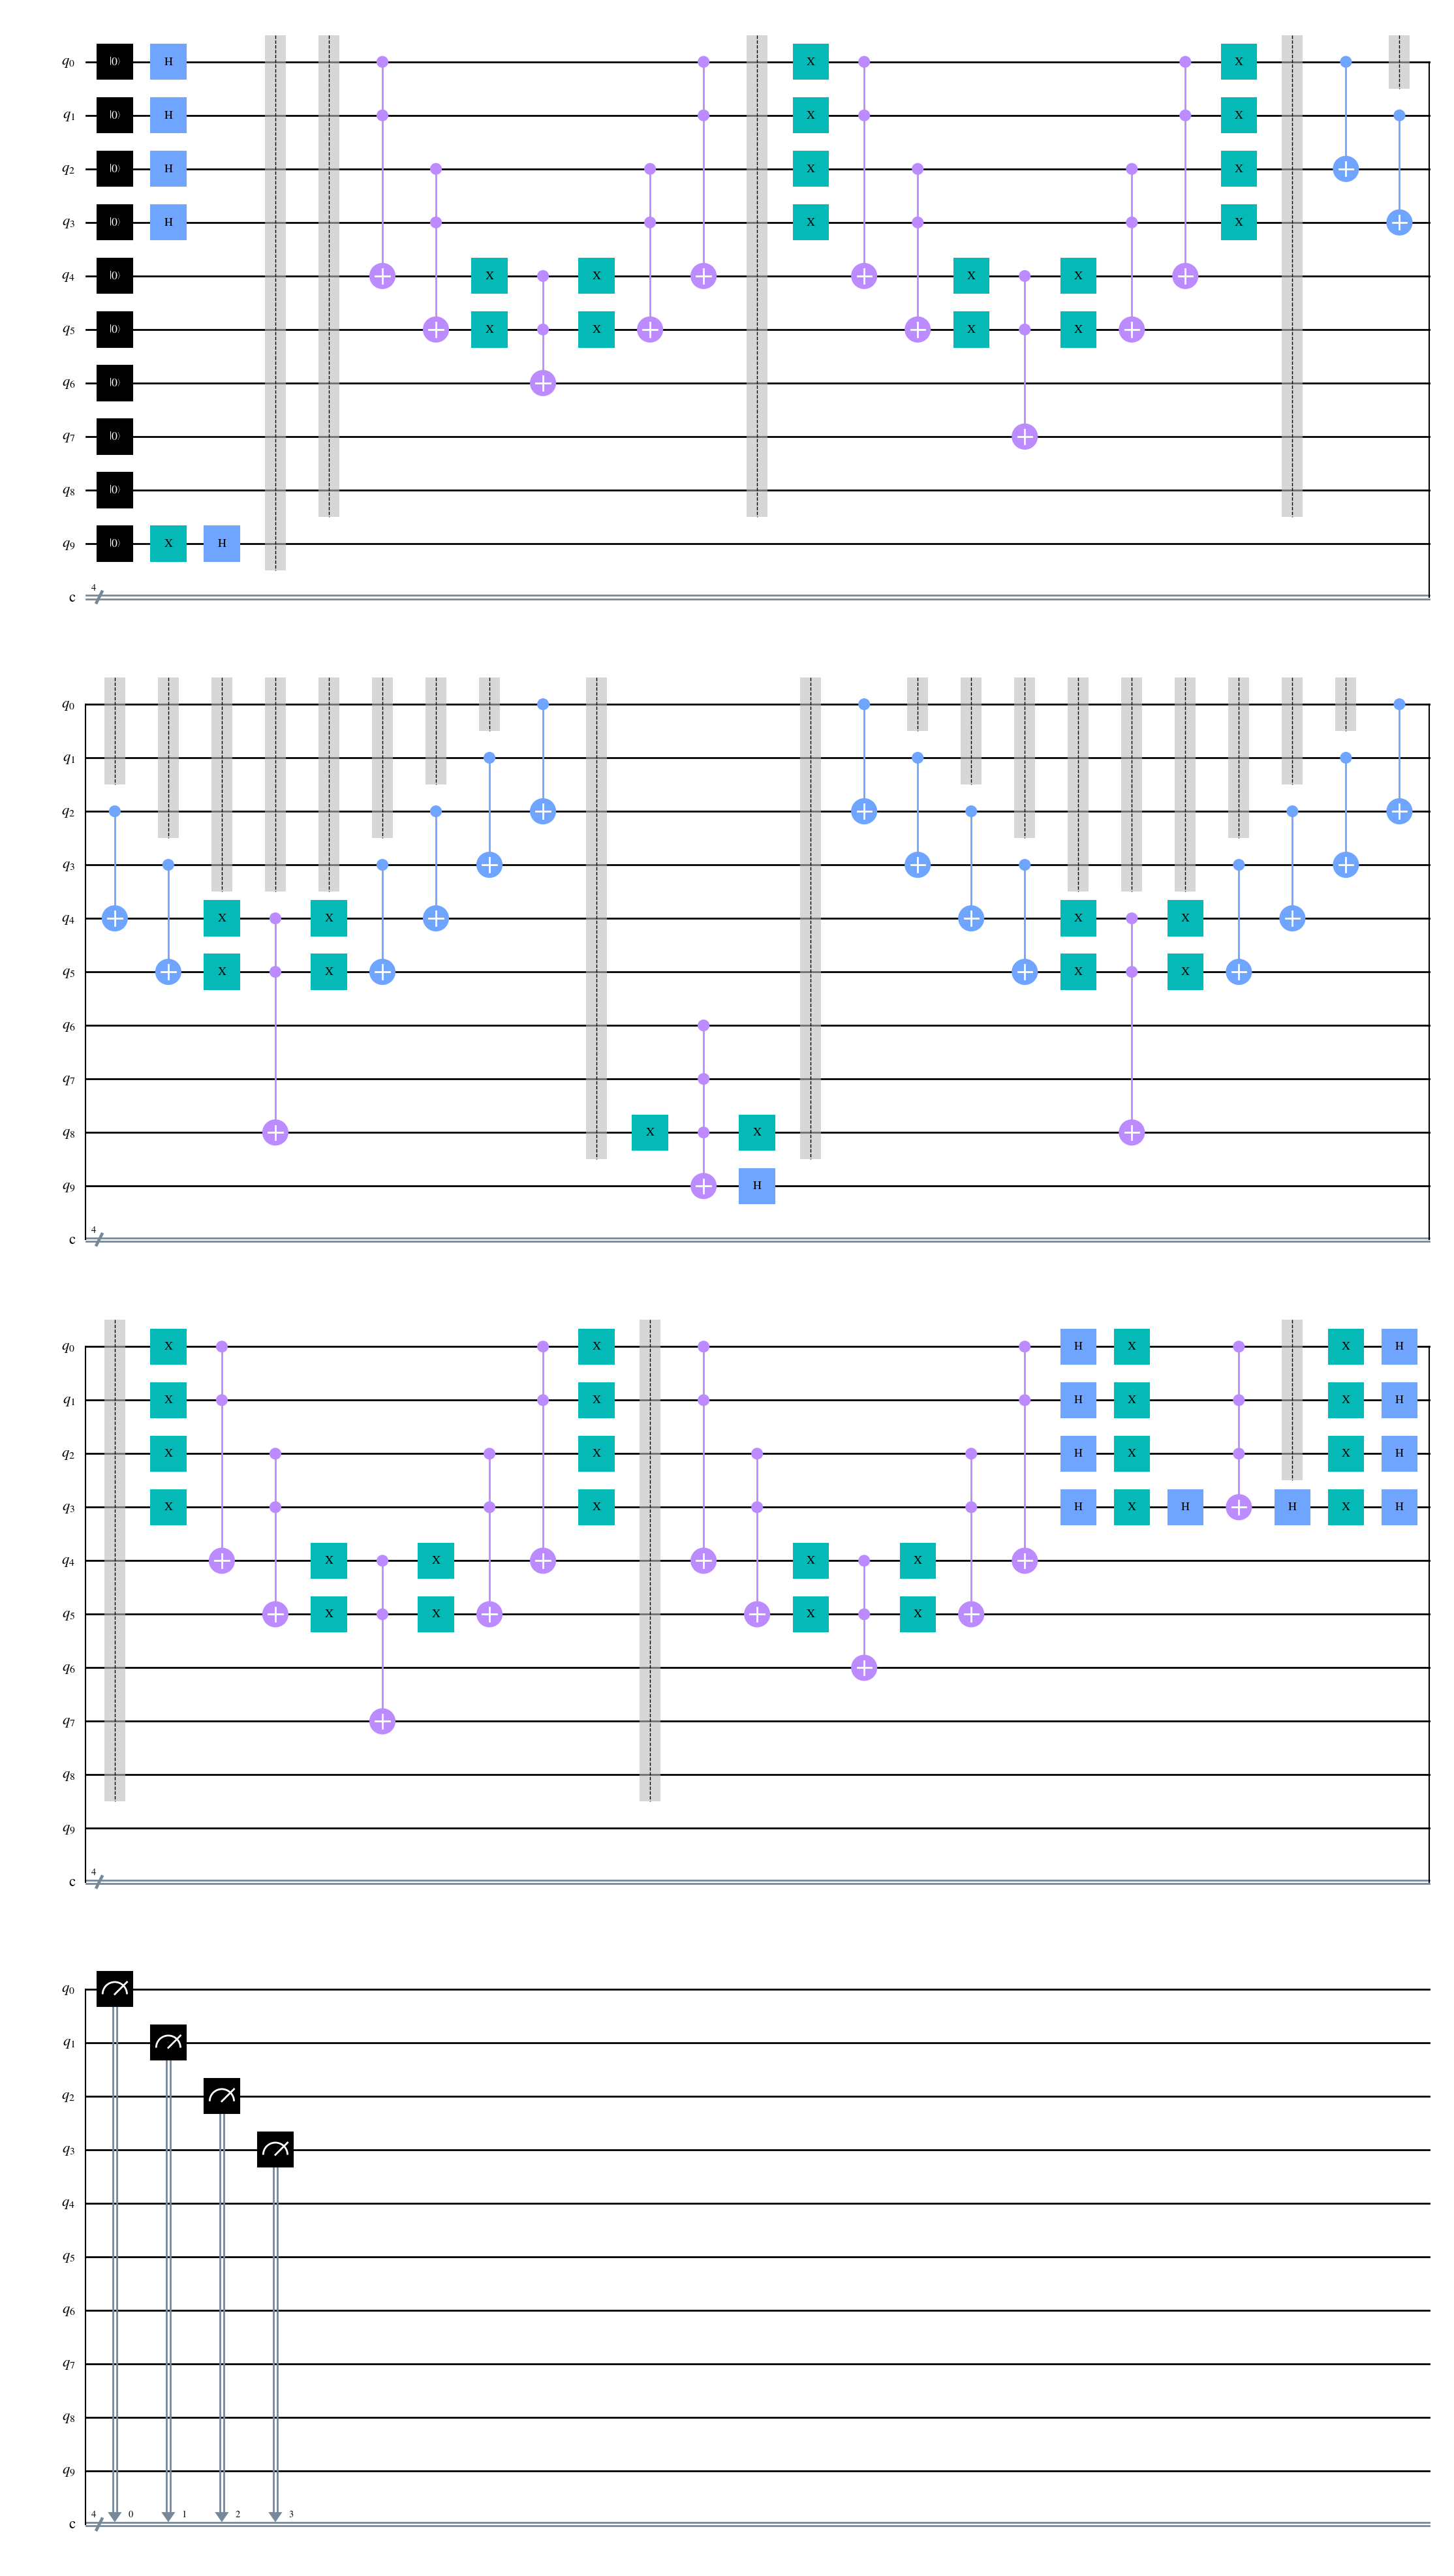

In [78]:
n_qubit = 10
n_matching = 4
grover_circuit = QuantumCircuit(n_qubit, n_matching)
grover_circuit.reset(range(0, n_qubit))
grover_circuit = initialize_s(grover_circuit, n_qubit, n_matching)
grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
for i in range(1):
    grover_circuit = violate_state_11(grover_circuit)
    grover_circuit = violate_state_00(grover_circuit)
    grover_circuit = compare_node1_node2(grover_circuit)
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8])
    grover_circuit.x([8])
    grover_circuit.mcx([6, 7, 8], 9)
    grover_circuit.x([8])
    grover_circuit.h([9])
    grover_circuit = compare_node1_node2(grover_circuit)
    grover_circuit = violate_state_00(grover_circuit)
    grover_circuit = violate_state_11(grover_circuit)
    grover_circuit = diffuser(grover_circuit, 4)
grover_circuit.measure([0, 1, 2, 3], [0, 1, 2, 3])
grover_circuit.draw(output = "mpl")

In [79]:
from qiskit import BasicAer, Aer,execute
from qiskit.providers.aer import AerSimulator
sim = Aer.get_backend('aer_simulator')


In [80]:
job = execute(grover_circuit, backend = sim, shots = 25600)
counts = job.result().get_counts()

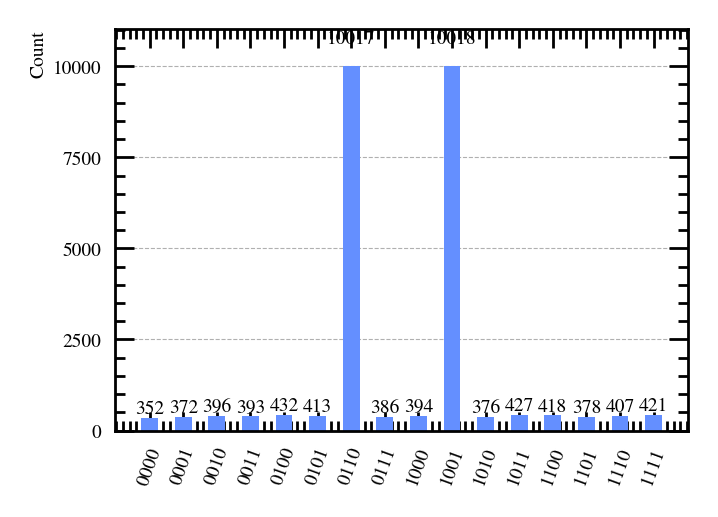

In [81]:
plot_histogram(counts)
